# FANTASTX reconstruction of a CdTe-tellurene interface

## TEM
TEM is an excellent experimental method for directly observing the atomic structure of materials, with atomic resolution. In the case of grain boundaries, an experimental TEM image captures the orientation of both the grains correctly. However, in the interface region the more stochastic nature of the atomic configuration renders even the atomic resolution of TEM insufficient for decisive insight into the atomic configuration of the interface. It is only by matching images produced from forward TEM simulations to the experimental image that a proposed atomic configuration can be validated. FANTASTX utilizes Earl J. Kirkland's [incostem](https://github.com/jhgorse/kirkland) program to conduct these TEM simulations, wrapped by the [Ingrained](https://github.com/MaterialEyes/ingrained-lite). For technical details beyond the YAML input parameters which are needed to conduct TEM simulations using FANTASTX, which will be covered [later](#tem_yaml_inputs) in this example, please refer to the Ingrained documentation.

The metric which is used to quantify the similarity between the simulated and experimental images is the [structural similarity index](https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html).

## CdTe-tellurene

In this example, we will use FANTASTX to invert an experimental TEM image which corresponds to two CdTe grains with a monolayer of Tellurene in the interface, originating from [this](https://pubs.rsc.org/en/content/articlelanding/2019/nr/c9nr02342a) publication:

<p style="text-align:center;"><img src="images/tellurene.png" alt="tellurene" width="1000" height="1000"/></p>

<!-- It can be observed that the structure exhibits periodicity along the grain boundary direction. As such, to minimize computational effort, we focus on a small slice of the image:
<p style="text-align:center;"><img src="images/tellurene_sliced.png" alt="tellurene" width="500" height="500"/></p> -->

## Trimming the image
It can be observed that the structure exhibits periodicity along the grain boundary direction. As such, to minimize computational effort, we focus on a small slice of the image. Note that the dimension of each image is (x pixels, y pixels, 4 channels).

Here, we trim the image, and save the figure both using pyplot and numpy.

/home/dgunruh/anaconda3/envs/py37/lib/python3.7/site-packages/pySPM/utils/misc.py:135: UserWarning: the library tqdm cannot be found. All progressbar will be disabled.
  warn("the library tqdm cannot be found. All progressbar will be disabled.")


Image dimensions: (206, 668, 4)
Trimmed image dimensions: (100, 94, 4)


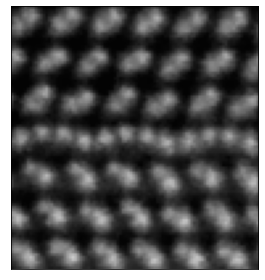

In [2]:
import matplotlib.pyplot as plt
from ingrained import image_ops
import os
import numpy as np

png_file = os.getcwd() + "/images/tellurene.png"
smaller_png_file = os.getcwd() + "/images/tellurene_sliced.png"
numpy_file = os.getcwd() + "/images/tellurene_sliced.npy"
raw_pixel_values = image_ops.image_open(png_file)
print(f"Image dimensions: {raw_pixel_values['Pixels'].shape}")
trimmed_pixel_values = raw_pixel_values['Pixels'][42:142, 246:340]
print(f"Trimmed image dimensions: {trimmed_pixel_values.shape}")

fig = plt.figure()
plt.imshow(trimmed_pixel_values) 
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
plt.tight_layout()
plt.savefig(smaller_png_file, format='png', dpi=1000)
np.save(numpy_file, trimmed_pixel_values)

## Obtaining the atomic configuration of the grains

While our objective is the atomic configuration of the interface region, we must start by first determining the atomic configuration of the two grains on the sides of the interface. This can be done in two ways:

* Apply [Ingrained](https://github.com/MaterialEyes/ingrained-lite), our automated grain alignment tool
* Manually align the grains

In this case, as the grains are simple CdTe layers, we assembled them manually, capping the layers with H on either side (though fixing the outer atoms renders this step not strictly necessary). 

<p style="text-align:center;"><img src="images/CdTe_grains_a.png" alt="CdTe_grains" width="400" height="200"/></p>

These atomic positions were aligned as closely with the experimental image as possible, translating them in the x, y and z directions using the atomic visualization program that was employed (Vesta). It was then saved in the VASP POSCAR format for input to FANTASTX. If the grains were more complex, then Ingrained would have been employed.

## Determining the Ingrained STEM parameters

The next step is to determine the STEM simulation parameters, fed into the [incostem](https://github.com/jhgorse/kirkland) program via [Ingrained](https://github.com/MaterialEyes/ingrained-lite). Several STEM parameters can be tuned, but here we focus on a sparse selection of parameters:

1. **The pixel size**
2. **The interface width**
3. **The STEM defocus**

The pixel size determines the number of pixels in the final image. This setting is tuned to match the size of the simulated image. Here, we set it to be **0.26**. 
The interface width allows additional stretching the interface region. Here we do not do this, we instead set this parameter to be **0**.
Finally, the defocus tunes the resolution of the simulated image. Here, we find the optimal setting to be **1.67**.

The output of the ingrained STEM simulations is an image which only has 1 channel, so to compare against the experimental image we flatten the experimental image into 1 channel by averaging the 4 channels.

Initial score SSIM of the CdTe grains vs the experimental image: 0.3665047657205235


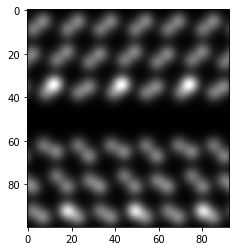

In [3]:
from ingrained.structure import Bicrystal

opt_params = [0.26, 0, 1.67]

# bicrys_model = Bicrystal(poscar_file='inputs/POSCAR_init_supercell')
bicrys_model = Bicrystal(poscar_file='inputs/CdTe_grain_POSCAR')
sim_img, __ = bicrys_model._get_image_cell(pix_size=opt_params[0], interface_width=opt_params[1],
                                           defocus=opt_params[2], view=False)
sim_img = sim_img[32:132]
plt.imshow(sim_img, cmap = 'gray')

exp_prev = np.load('images/tellurene_sliced.npy')
exp_prev = np.mean(exp_prev, axis=2)[:,1:] # flatten the numpy image to only have 1 channel
match_ssim = image_ops.score_ssim(sim_img, exp_prev)
print(f"Initial score SSIM of the CdTe grains vs the experimental image: {match_ssim}")

## Running FANTASTX

Current example shows FANTASTX search on grain boundary structures to match a target STEM image. However, FANTASTX is modular and supports different geometries such as bulk structures, surfaces, nanocrystals and molecules and can match characterization data such as PDF, XRD, STM image, XANES in addition to TEM images. 


### Preparing the input.yaml file

input.yaml file includes all the user specifications for the FANTASTX search. These parameters are further divided into various groups and sub-groups. Some of the parameters are specific to the type of search and then there are common parameters. The common group of parameters across any FANTASTX search are - 

#### GA/basinhopping related parameters

```yaml
population_limits:
    initial_population: 30
    total_population: 200
    pool: 40
    
fingerprint_params:
    label: 'bag-of-bonds' # "bag-of-bonds", "valle-oganov", or "rematch-soap"
    tolerance: [0.03, 0.7] # (length 2 array) for bag-of-bonds, (float) for valle-oganov or rematch soap
    zbounds: [15.91 , 27.09] # [z_low, z_high]. optional parameter which will trim the fingerprinting region of the supercell to be bounded by the provided values.

select_params:
    objective_fn_type: multi
    num_required_above_50: 20
    num_models_before_pareto: 30
    operators: ['perturb_sites', 'perturb_comp', 'fraction_slice'] #possible genetic operations
    operator_assignment: 'fixed' # auto-adaptive or fixed
    operator_frequencies: [0.25, 0.25, 0.5] # make sure add up to 1, and has same length as 'operators'. Should be [0.87, 0.13] for original gb implementation.
    
mating_constraints:
    num_parents_fraction: 0.1
    attach_type_fraction: 0.3

basinhopping_constraints:
    perturb_box: [[0.4, 0.6], [0.4, 0.6], [0.6, 0.4]]
    jump_fraction: 0.12
```

#### energy code related parameters:

```yaml
energy_code: vasp
energy_exec_cmd: mpirun vasp_std > job.log 
```
```yaml
energy_code: lammps
energy_obj_fn: mu_based
energy_exec_cmd: srun --mpi=pmi2 lmp_mpi -in in.min
```

#### fingerprinting parameters:

```yaml
fingerprint_params:
    label: 'bag-of-bonds' # "bag-of-bonds", "valle-oganov", or "rematch-soap"
    tolerance: [0.03, 0.7] # (length 2 array) for bag-of-bonds, (float) for valle-oganov or rematch soap
    zbounds: [15.91 , 27.09] # [z_low, z_high]. optional parameter which will trim the fingerprinting region of the supercell to be bounded by the provided values.
```

#### parallelization related parameters
```yaml
workers: # contains specifications for each dask worker job
    cluster: "PBS"            # Specify type of scheduler
    max_workers: 10           # Number of parallel calculations of models
    num_cores: 1              # cpus-per-task option
    total_mem: "80GB"         # total memory for the job (--mem option)
    project_name: "cnm12345"  # project under which job to be requested
    node_type: "ib0"          # infiniband or haswell or broadwell etc
    walltime: "96:00:00"      # estimated entire walltime a worker job shall run
    job_extra:                # any other PBS/SLURM submit options
         - "-l nodes=1:ppn=16:gen6"
    header_skip:
         - "-l select=1"
```


Now, the search specific parameters - > Geometry and the experimental simulation related parameters

#### structure and geometry related
```yaml
structure_record:
    gb:
        init_gb_astr: /sandbox/vkolluru/FX_CdTe_tellurene/run_1_dfp/POSCAR_init_CdTe_tellurene
        iface_thickness: 4
        iface_z_mid: 0.5
        num_slices: 2
        hop_mate_frac: 1.3 # Currently not being used in code; TODO: Delete
        sd_true_above: 0.37  # NEW param: z-fractional coords above which sd is True
        sd_true_below: 0.63  # NEW param: z-fractional coords below which sd is True
```

```yaml
structure_record:
    cluster:
        max_dia: 7
        box_abc:
            - 18
            - 18
            - 18
        lin_sph_ratio: 0.999
        radius_rand_linear: 1.75
        tol_rand_linear: 0.2
```

#### composition space

```yaml
species:
    species1:
        name: Te
        min_num: 3
        max_num: 5
        mu: -3.1433  
    species2:
        name: Cd
        min_num: 0
        max_num: 0
        mu: -0.9062 
    species3:
        name: H
        min_num: 0
        max_num: 0
        mu: -1.116967 # PBE H atom
```


#### experimental characterization related
```yaml
exp_sim_1: 'GB_STEM'
exp_sim_1_params:
    dm3_path: null
    progress_file: null
    ing_opt_params: [0.26, 0, 1.66938749]
    sim_patch_dims:
        #x: [8, 144]    # corresponds to width
        y: [32, 132]  # corresponds to height
    supercell_dimensions: [1, 3, 1]
    #resize_sim_img: [93, 100] # give as [width, height]
```

```yaml
exp_sim_1: PDF
exp_sim_1_params:
    exp_pdf_file: /path_to_exp_pdf/exp_pdf_data.txt
    stretch: 1.03
    Uiso_val: 0.02
    scale: 2.0
    delta1: 1.0
    delta2: 4.0
    qdamp: 0.01
    xmin: 1.5
    xmax: 7.0
    minimize_method: L-BFGS-B
```

Gather the `input.yaml` file with information about the locations of energy code files,  `bicrystal.POSCAR.vasp`, `exp_img.npy`, and any initial guess POSCARs (optional)

At this point, we are ready to run FANTASTX.

We will not show the FANTASTX run here.. (Switch to Carbon)